In [1]:
import collections
import os
import warnings
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmeta.modules import MetaLinear, MetaModule, MetaSequential
from torchmeta.toy import Sinusoid
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
def get_dataloader(
    config: Dict[str, int]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:
    train_dataset = Sinusoid(
        num_samples_per_task=config["num_shots"] * 2,
        num_tasks=config["num_task_batch_train"] * config["task_batch_size"],
        noise_std=None,
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=config["task_batch_size"]
    )

    val_dataset = Sinusoid(
        num_samples_per_task=config["num_shots"] * 2,
        num_tasks=config["num_task_batch_train"] * config["task_batch_size"],
        noise_std=None,
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=config["task_batch_size"]
    )

    test_dataset = Sinusoid(
        num_samples_per_task=config["num_shots"] * 2,
        num_tasks=config["num_task_batch_test"] * config["task_batch_size"],
        noise_std=None,
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=config["task_batch_size"]
    )
    return train_dataloader, val_dataloader, test_dataloader

In [3]:
class FCNet(MetaModule):
    def __init__(self, in_dimension: int, out_dimension: int) -> None:
        super(FCNet, self).__init__()
        self.in_dimension = in_dimension
        self.out_dimension = out_dimension
        self.hidden_size = 40

        self.linears = MetaSequential(
            MetaLinear(1, self.hidden_size),
            nn.ReLU(),
            MetaLinear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            MetaLinear(self.hidden_size, 1),
        )

    def forward(
        self, x: torch.Tensor, params: Optional[collections.OrderedDict] = None
    ) -> torch.Tensor:
        pred = self.linears(x, params=self.get_subdict(params, "linears"))
        return pred

In [4]:
def train_maml(
    num_shots: int,
    device: str,
    task_batch_size: int,
    task_batch: Dict[str, List[torch.Tensor]],
    model: FCNet,
    criterion: nn.MSELoss,
    optimizer: torch.optim.Adam,
) -> float:
    model.train()

    xs, ys = task_batch
    support_xs = xs[:, :num_shots, :].to(device=device).type(torch.float)
    query_xs = xs[:, num_shots:, :].to(device=device).type(torch.float)
    support_ys = ys[:, :num_shots, :].to(device=device).type(torch.float)
    query_ys = ys[:, num_shots:, :].to(device=device).type(torch.float)

    outer_loss = torch.tensor(0.0, device=device)

    for support_x, support_y, query_x, query_y in zip(
        support_xs, support_ys, query_xs, query_ys
    ):
        support_pred = model(support_x)
        inner_loss = criterion(support_pred, support_y)

        params = gradient_update_parameters(
            model, inner_loss, step_size=0.01, first_order=False
        )

        query_pred = model(query_x, params=params)
        outer_loss += criterion(query_pred, query_y)

    outer_loss.div_(task_batch_size)

    model.zero_grad()
    outer_loss.backward()
    optimizer.step()
    return outer_loss.item()

In [5]:
def test_maml(
    num_shots: int,
    device: str,
    task_batch_size: int,
    task_batch: Dict[str, List[torch.Tensor]],
    model: FCNet,
    criterion: nn.MSELoss,
) -> float:
    model.eval()

    xs, ys = task_batch
    support_xs = xs[:, :num_shots, :].to(device=device).type(torch.float)
    query_xs = xs[:, num_shots:, :].to(device=device).type(torch.float)
    support_ys = ys[:, :num_shots, :].to(device=device).type(torch.float)
    query_ys = ys[:, num_shots:, :].to(device=device).type(torch.float)

    outer_loss = torch.tensor(0.0, device=device)

    for support_x, support_y, query_x, query_y in zip(
        support_xs, support_ys, query_xs, query_ys
    ):
        support_pred = model(support_x)
        inner_loss = criterion(support_pred, support_y)

        params = gradient_update_parameters(
            model, inner_loss, step_size=0.01, first_order=False
        )

        query_pred = model(query_x, params=params)
        outer_loss += criterion(query_pred, query_y)

    outer_loss.div_(task_batch_size)
    return outer_loss.item()

In [6]:
def save_model(output_folder: str, model: FCNet, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: FCNet, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [7]:
def print_loss_graph(train_losses: List[float], val_losses: List[float]) -> None:
    plt.figure(figsize=(8, 6), dpi=80)

    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

In [9]:
config = {
    "num_shots": 10,
    "output_folder": "saved_model",
    "task_batch_size": 100,  # 필수
    "num_task_batch_train": 1000,  # 필수
    "num_task_batch_test": 300,  # 필수
    # "device": "cuda",  # 필수
    "device": "cpu",  # 필수
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = FCNet(in_dimension=1, out_dimension=1).to(device=config["device"])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s, train_loss=1.1742, val_loss=1.1711]


Model is saved in saved_model/maml_regression.th


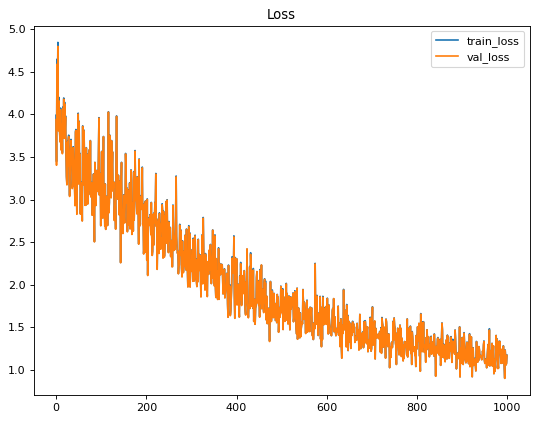

In [10]:
# 메타-트레이닝
with tqdm(
    zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]
) as pbar:
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        train_loss = train_maml(
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_loss = test_maml(
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_loss="{0:.4f}".format(train_loss), val_loss="{0:.4f}".format(val_loss)
        )

# 모델 저장하기
save_model(
    output_folder=config["output_folder"], model=model, title="maml_regression.th"
)

print_loss_graph(train_losses=train_losses, val_losses=val_losses)

In [11]:
# 모델 불러오기
load_model(
    output_folder=config["output_folder"], model=model, title="maml_regression.th"
)

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        test_loss = test_maml(
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
        )

        sum_test_losses += test_loss
        pbar.set_postfix(
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1))
        )

Model is loaded


100%|██████████| 300/300 [00:25<00:00, 11.98it/s, test_loss=1.1711]


***